In [1]:
# %env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
# !echo $DRJIT_LIBLLVM_PATH

In [2]:
# %%bash
# ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [3]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt

mi.set_variant('cuda_ad_rgb')
# mi.set_variant('llvm_ad_rgb')

### Numeric tests: spherical integrals

In [4]:
from sh_utils import eval_basis_on_hemisphere

d, sh_basis, quad_W = eval_basis_on_hemisphere(max_order=2, N=64)
# integrand = quad_W * sh_basis * 1.0
integrand = quad_W * 1.0
dr.sum(integrand) - dr.four_pi  # should be zero

[6.67572e-06]

16:	4.392576e-02
32:	3.109217e-03
64:	1.367331e-03
128:	6.818771e-05
256:	2.527237e-05
512:	8.821487e-06
1024:	2.384186e-06


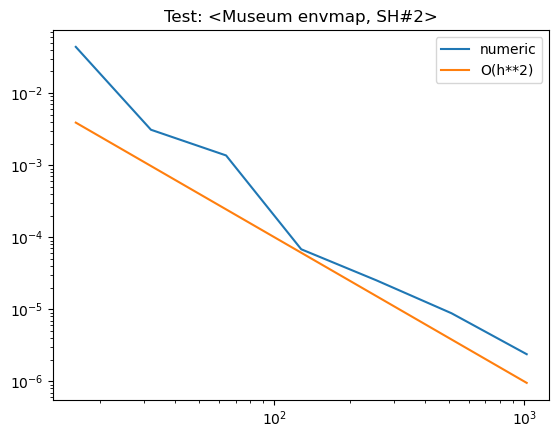

In [5]:
from sh_utils_test import test_spherical_integrate_env

test_spherical_integrate_env(2)

### Numeric tests: SH fitting

16:	1.039505e-04
32:	4.768372e-06
64:	9.536743e-07
128:	0.000000e+00
256:	0.000000e+00
512:	9.536743e-07
16:	8.308887e-05
32:	2.384186e-07
64:	7.152557e-07
128:	5.364418e-07
256:	5.364418e-07
512:	5.960464e-07
Max orthogonality error: 1.311e-06


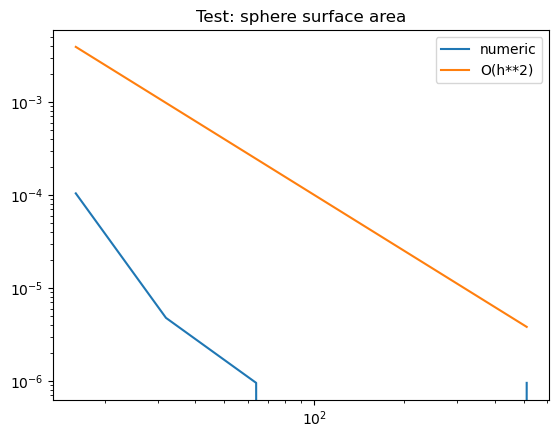

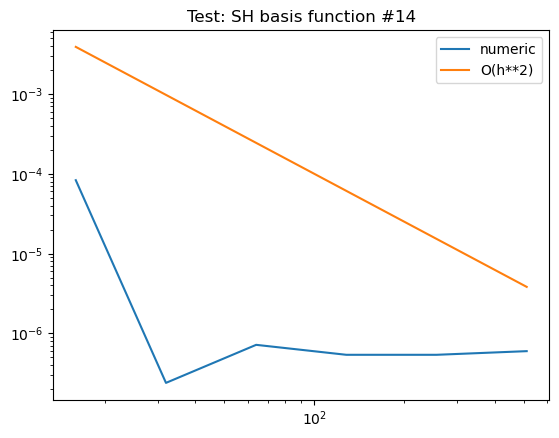

In [6]:
from sh_utils_test import test_spherical_integrate_0, test_spherical_integrate_1, test_spherical_integrate_2

test_spherical_integrate_0();
test_spherical_integrate_1(index=14);

# # envmap = mi.load_dict({
# #     "type": "envmap",
# #     "filename": "/home/jonathan/Documents/mi3-balance/resources/data/common/textures/museum.exr"
# # })

test_spherical_integrate_2(max_order=3);

# TODO: fitting to a *hemisphere* for the radiance cache might require some care.
# - all measurement vectors should be duplicated and reflected about the z-axis
# - fit only the even SH basis functions (even wrt +-z, at least)

In [7]:
from sh_utils_test import test_fit_envmap, test_fit_sh

# # Tests with 3D plotting

# test_fit_envmap(9)
# # test_fit_sh(9)

### SH fitting for radiance fields on mesh surfaces, $L_o(\omega)$

Fit visualization at one surface point

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..47.312656].


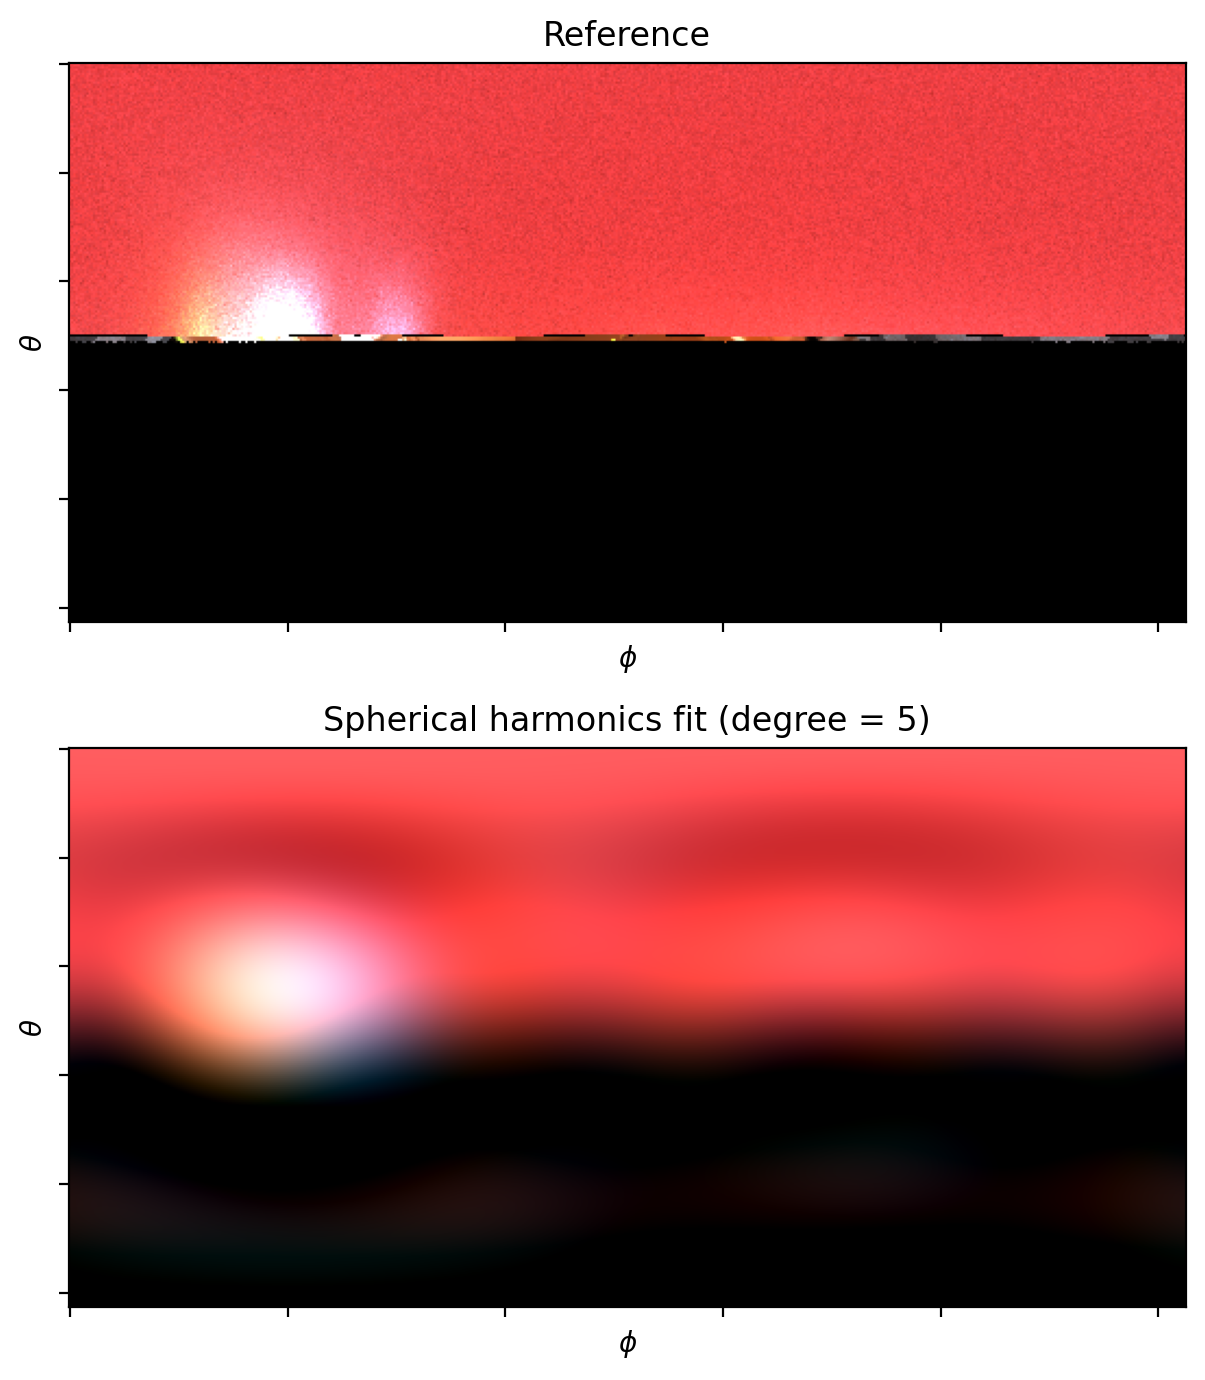

In [8]:
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/cbox/cbox.xml")
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/matpreview/matpreview.xml")

from sh_fitting import fit_sh_on_mesh_vertex

fit_sh_on_mesh_vertex(scene, mesh_idx=2, mesh_vtx_idx=1000, max_order=5, Nquad=512, spp=256)
# fit_sh_on_mesh_vertex(scene, mesh_idx=6, mesh_vtx_idx=3, max_order=5, Nquad=256, spp=256)

Fit the scene-wide SH radiance cache and render

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.5413].


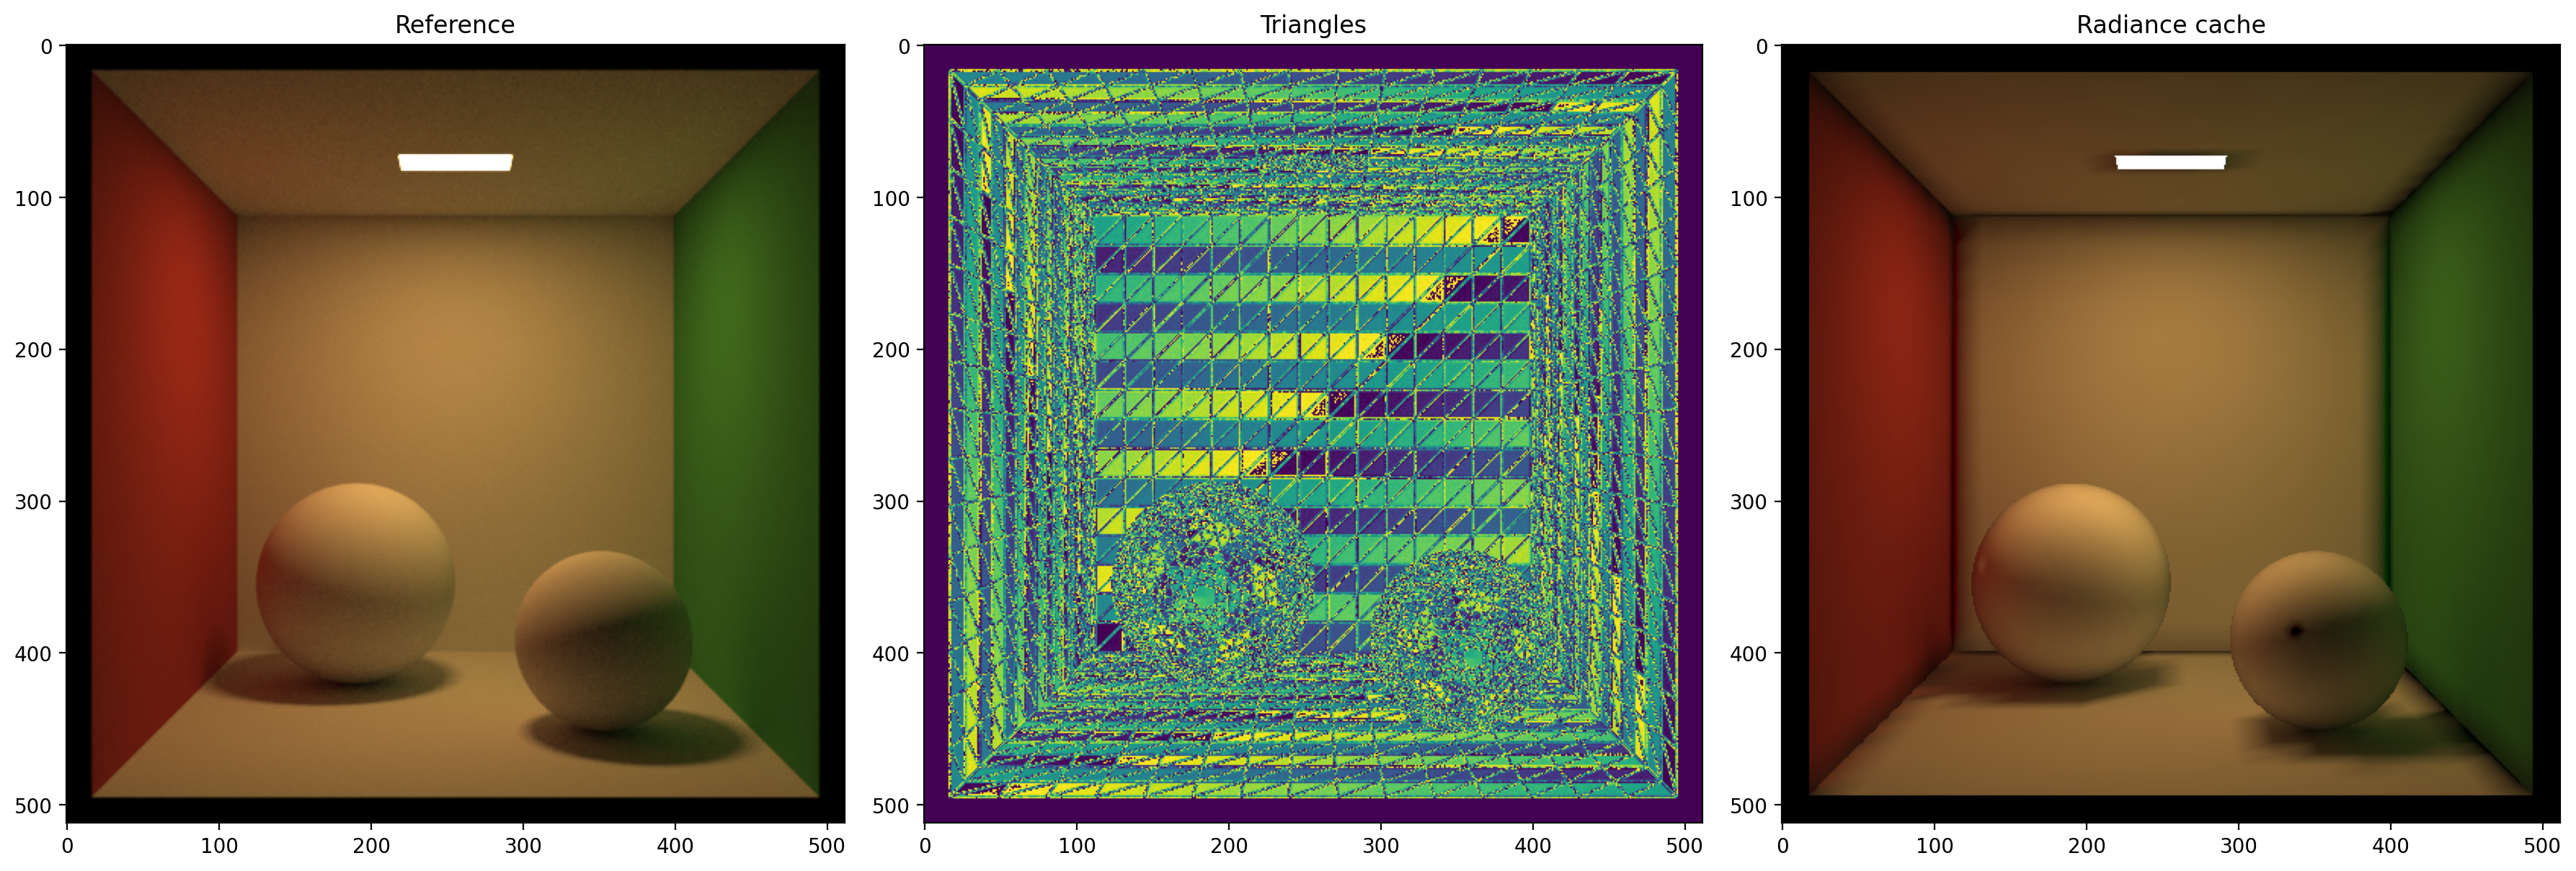

In [10]:
from sh_fitting import fit_sh_on_scene, render_scene
import matplotlib.pyplot as plt
import numpy as np

# # scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/cbox/cbox.xml")
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox.xml")
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/matpreview/matpreview.xml")
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/staircase/scene.xml")

max_order = 3
fit_sh_on_scene(scene, max_order, Nquad = 64, spp = 64)    # matpreview, 30s
# fit_sh_on_scene(scene, max_order, Nquad = 256, spp = 256)    # matpreview, 30s
image, img_res = render_scene(scene, max_order)

# TODO: find out how to plot mi.Color3f images
out = np.stack((
    mi.TensorXf(image.x, shape=(img_res[1], img_res[0])).numpy(),
    mi.TensorXf(image.y, shape=(img_res[1], img_res[0])).numpy(),
    mi.TensorXf(image.z, shape=(img_res[1], img_res[0])).numpy()), axis=2)

plt.figure(figsize=(18,10), dpi=200); 
plt.subplot(131); plt.imshow(mi.render(scene) ** (1.0/2.2)); plt.title("Reference")
prim = mi.render(scene, integrator = mi.load_dict({'type': 'aov', 'aovs': 'dd.y:prim_index'}))
plt.subplot(132); plt.imshow(prim.numpy().astype('int') % 32); plt.title("Triangles")
plt.subplot(133); plt.imshow(out ** (1.0/2.2)); plt.title("Radiance cache")
plt.tight_layout()

In [11]:
from sh_fitting import visualize_fit

visualize_fit(scene, max_order)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120
